In [ ]:
from utils import NuImagesDataSet
from models import image_encoder
import numpy as np
import tensorflow as tf 

data_root = '../../../../datasets/nuimages'
nuimd = NuImagesDataSet(data_root)

# Data pipeline

In [2]:
batch_size = 16

semantic_file_path_train = '../../../../datasets/nuim_semantic_train/'
semantic_file_path_val = '../../../../datasets/nuim_semantic_val/'

camera_train_files_paths, camera_val_files_paths = nuimd.get_cameras_train_val_file_paths()
semantic_train_files_paths, semantic_val_files_paths = nuimd.get_train_val_file_paths(semantic_file_path_train, semantic_file_path_val)

train_files = np.concatenate((np.array(camera_train_files_paths)[..., np.newaxis], np.array(semantic_train_files_paths)[..., np.newaxis]), axis=1)
val_files = np.concatenate((np.array(camera_val_files_paths)[..., np.newaxis], np.array(semantic_val_files_paths)[..., np.newaxis]), axis=1)
print(f'train files shape = {train_files.shape}', f'val files shape = {val_files.shape}')

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)

def parse_samples(file_paths):
    image_path = file_paths[0]
    semantic_path = file_paths[1]
    x = nuimd.get_image(image_path)
    y = nuimd.read_binary_file(semantic_path, dtype=tf.float32, shape=(56,100,3))
    return (x,y)

train_dataset = train_dataset.shuffle(buffer_size=train_dataset.cardinality(),reshuffle_each_iteration=True).map(parse_samples, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(1)

val_dataset = val_dataset.map(parse_samples, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset= val_dataset.batch(batch_size).prefetch(1)

Loaded 67279 sample(s) in 0.053s,
Loaded 872181 sample_data(s) in 1.906s,
Loaded 16445 sample(s) in 0.018s,
Loaded 213185 sample_data(s) in 0.486s,
train files shape = (67279, 2) val files shape = (16445, 2)


# Test datapipeline 

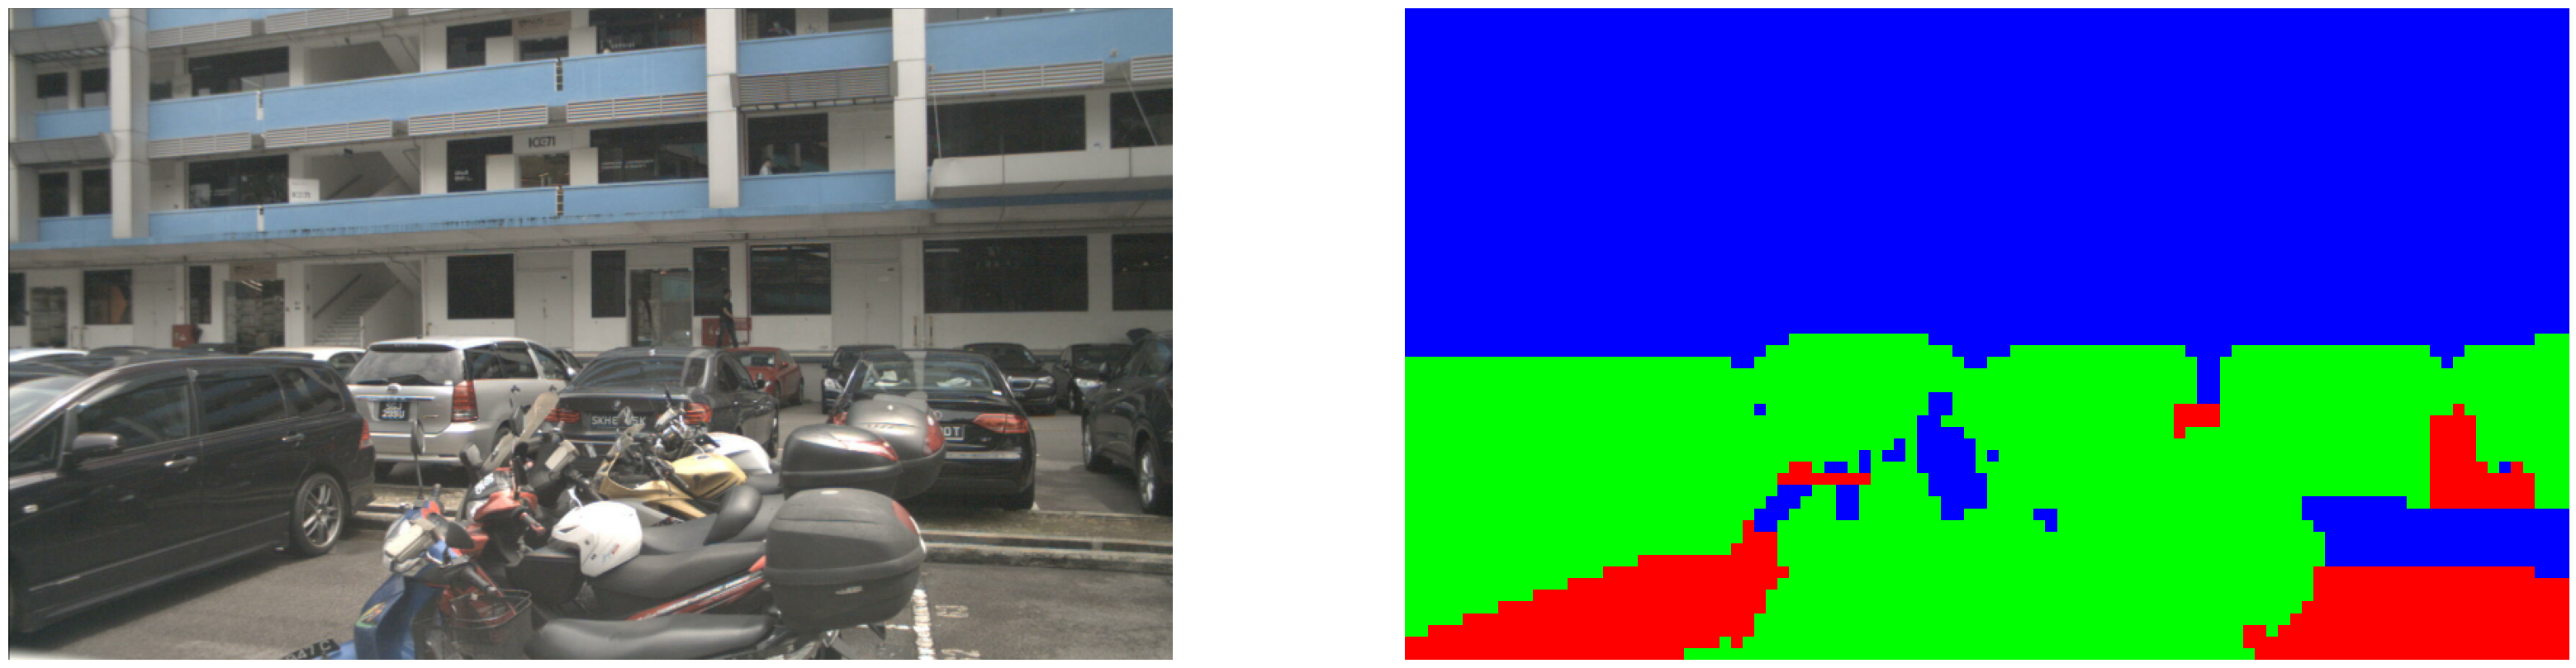

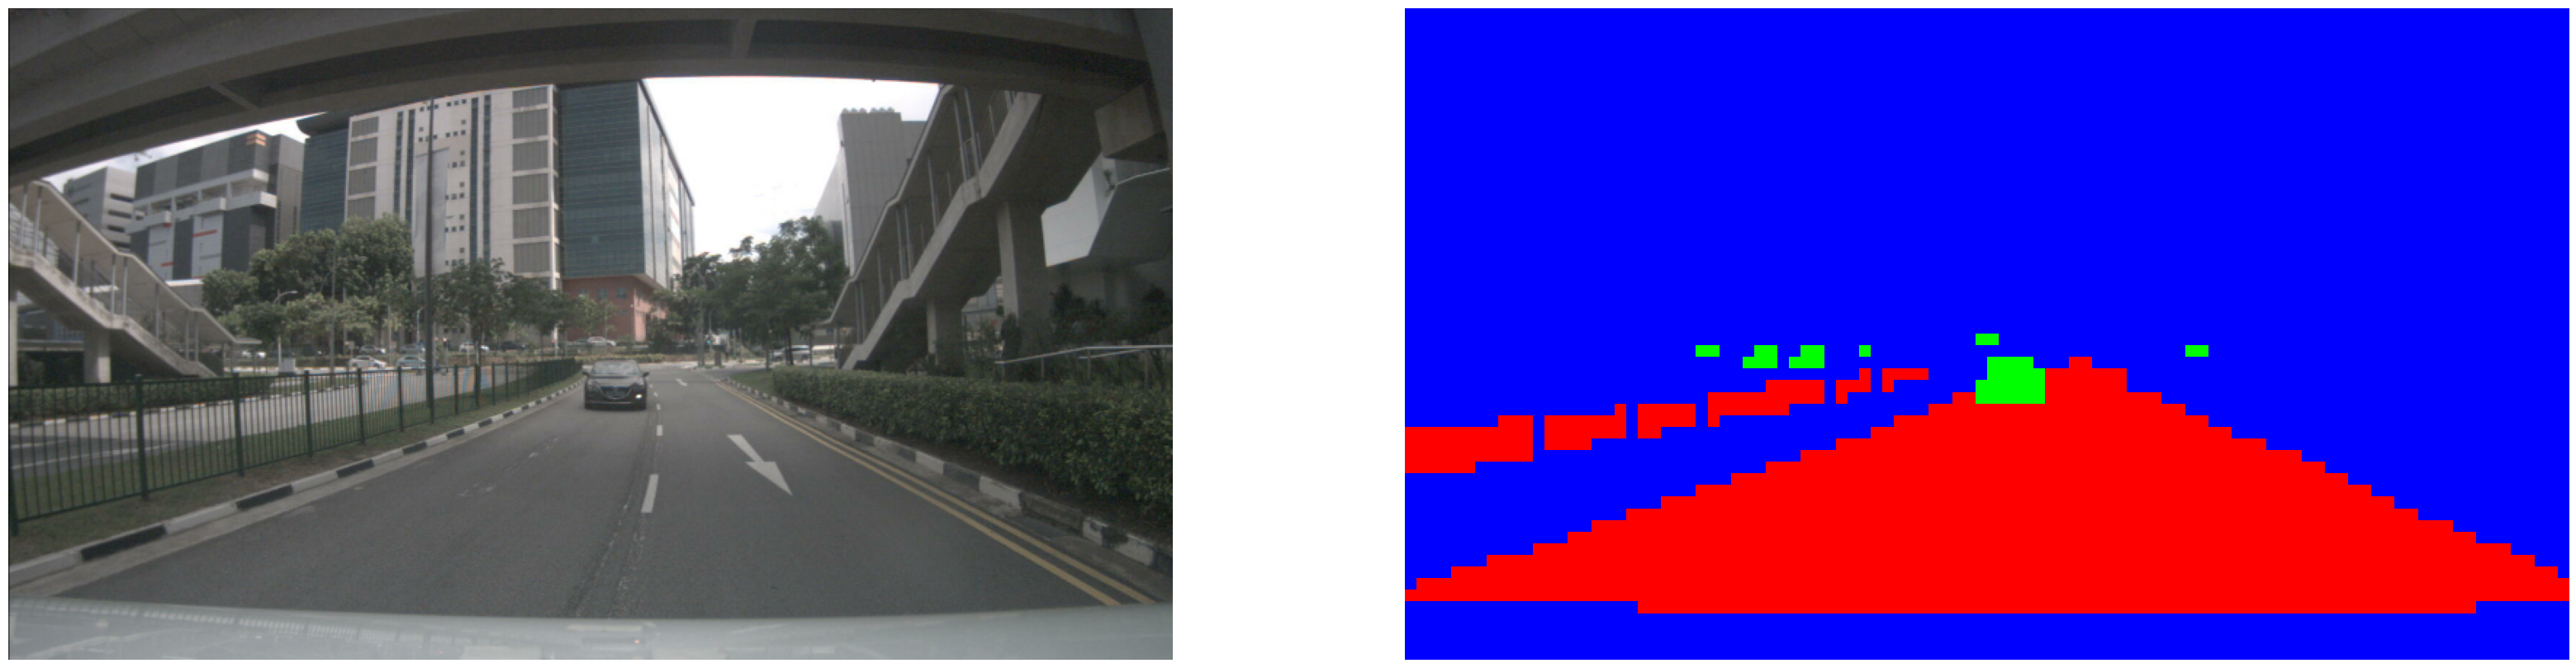

In [3]:
from matplotlib import pyplot as plt 

def plot_sample(image, mask):
    plt.figure(figsize=(40,40))

    plt.subplot(1,2,1)
    plt.axis(False)
    plt.imshow(image/255.0)

    plt.subplot(1,2,2)
    plt.axis(False)
    plt.imshow(mask)

    plt.show()

for x, y in train_dataset:
    image = x[0]
    mask = y[0]
    break
plot_sample(image,mask)


## Custom callbak

In [4]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.best_metric = 0

    def my_optimizer(self, epoch):
        lr = {10: 1e-4, 20:1e-5}
        if epoch in lr.keys():
            print(f'\n set learning rate to {lr[epoch]}')
            tf.keras.backend.set_value(self.model.optimizer.lr, lr[epoch])
           
    def on_epoch_end(self, epoch, logs=None):
        self.my_optimizer(epoch)
        if logs.get("val_Mean_IOU")>self.best_metric:
            self.best_metric = logs.get("val_Mean_IOU")
            self.model.save_weights(f'./model_weights/{self.model_name}.h5')
            print(f'\n {self.model_name} saved best weights')

        

# Train model

In [ ]:
tf.config.optimizer.set_jit(True) # Enable XLA
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model = image_encoder((448,800,3), back_bone='EfficientNetB1', normalization = 'BatchNormalization', weights = 'imagenet')
# model = image_encoder((448,800,3), back_bone='EfficientNetB1', normalization = 'GroupNormalization', weights = 'imagenet')

log_dir = f"logs/image_encoder_effnetb1_batchnorm_bs20_imagenet"

loss = tf.keras.losses.CategoricalFocalCrossentropy()
optimizer = tf.keras.optimizers.AdamW(1e-3)
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch = '500,520'), MyCallback(log_dir.split('/')[-1])]
metrics = [
    tf.keras.metrics.MeanIoU(num_classes=3, name = "Mean_IOU", sparse_y_true= False, sparse_y_pred=False),
    tf.keras.metrics.IoU(num_classes=3, name = "road", target_class_ids = [0], sparse_y_true= False, sparse_y_pred=False),
    tf.keras.metrics.IoU(num_classes=3, name = "car", target_class_ids = [1], sparse_y_true= False, sparse_y_pred=False),
    tf.keras.metrics.IoU(num_classes=3, name = "nothing", target_class_ids = [2], sparse_y_true= False, sparse_y_pred=False)
    ]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_dataset, validation_data= val_dataset, epochs=25, callbacks=callbacks)

## Evaluate model

In [ ]:
model = image_encoder((448,800,3), back_bone='EfficientNetB1', normalization = 'GroupNormalization', weights = 'imagenet')
model.load_weights('./model_weights/image_encoder_effnetb1_groupnorm_bs20_imagenet.h5')
loss = tf.keras.losses.CategoricalFocalCrossentropy()
metrics = [
    tf.keras.metrics.MeanIoU(num_classes=3, name = "Mean_IOU", sparse_y_true= False, sparse_y_pred=False),
    tf.keras.metrics.IoU(num_classes=3, name = "road", target_class_ids = [0], sparse_y_true= False, sparse_y_pred=False),
    tf.keras.metrics.IoU(num_classes=3, name = "car", target_class_ids = [1], sparse_y_true= False, sparse_y_pred=False),
    tf.keras.metrics.IoU(num_classes=3, name = "nothing", target_class_ids = [2], sparse_y_true= False, sparse_y_pred=False)
    ]
model.compile(loss=loss, metrics=metrics)
model.evaluate(val_dataset)